<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-&amp;-declarations" data-toc-modified-id="Imports-&amp;-declarations-1">Imports &amp; declarations</a></span></li><li><span><a href="#Modeling-&amp;-evaluation" data-toc-modified-id="Modeling-&amp;-evaluation-2">Modeling &amp; evaluation</a></span></li><li><span><a href="#Analysis-&amp;-interpretation" data-toc-modified-id="Analysis-&amp;-interpretation-3">Analysis &amp; interpretation</a></span></li></ul></div>

# Getting to know Rexburg, Idaho, USA
**Where to live, where to eat, what to do**

_Coursera Applied Data Science Capstone Project, January 2020_

## Imports & declarations

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium
from folium.features import DivIcon

import capstone_functions as cf

from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score

In [2]:
rexburg_venues = pd.read_csv('data/rexburg_venues_cleaned.csv')

In [3]:
rexburg_venues.head()

,grid_section_lat,grid_section_long,venue,v_lat,v_long,category,group,type
0,43.839,-111.805791,Madison County Fair,43.830932,-111.796751,Flea Market,Flea Market,Shop & Service
1,43.839,-111.805791,The Church of Jesus Christ of Latter-day Saints,43.829912,-111.800706,Church,Spiritual Center,Professional & Other Places
2,43.839,-111.805791,Nature Park,43.834798,-111.801264,Park,Park,Outdoors & Recreation
3,43.839,-111.805791,Eagle park,43.837360,-111.798076,Park,Park,Outdoors & Recreation
4,43.839,-111.805791,Great Scott's,43.825128,-111.788920,Gas Station,Gas Station,Shop & Service


## Modeling & evaluation

We'd like to be able to identify parts of town that are similar so we can focus our friend's search for housing. We'll employ machine learning to cluster areas of town into groups with similar venues.

Since we don't have neighborhoods, and since most towns in the intermountain west are laid out as a grid, we'll divide Rexburg up into a grid and use the grid sections to represent "neighborhoods".

Let's use a $15\times15$ grid, which should give us a good balance between granularity and 

In [4]:
grid_size = 15
cf.draw_rexburg_map(grid_size=grid_size, grid_numbers=True)

In [5]:
for row in rexburg_venues.itertuples():
    rexburg_venues.loc[row.Index, 
                       'grid_section'] = cf.venue_grid_section(row.v_lat, 
                                                               row.v_long, 
                                                               grid_size)

rexburg_venues.grid_section = rexburg_venues.grid_section.astype(int)

In [6]:
rexburg_venues.head()

,grid_section_lat,grid_section_long,venue,v_lat,v_long,category,group,type,grid_section
0,43.839,-111.805791,Madison County Fair,43.830932,-111.796751,Flea Market,Flea Market,Shop & Service,49
1,43.839,-111.805791,The Church of Jesus Christ of Latter-day Saints,43.829912,-111.800706,Church,Spiritual Center,Professional & Other Places,63
2,43.839,-111.805791,Nature Park,43.834798,-111.801264,Park,Park,Outdoors & Recreation,32
3,43.839,-111.805791,Eagle park,43.837360,-111.798076,Park,Park,Outdoors & Recreation,18
4,43.839,-111.805791,Great Scott's,43.825128,-111.788920,Gas Station,Gas Station,Shop & Service,96


Now we'll cross-tabulate the grid sections by venue group. 

In [7]:
grid_categories = pd.crosstab(rexburg_venues.grid_section, rexburg_venues.group)
grid_categories = pd.DataFrame(index=range(1, grid_size**2 + 1)
                              ).join(grid_categories).fillna(0)
grid_categories.shape

(225, 156)

And min/max scale the data for clustering.

In [8]:
grid_categories_scaled = grid_categories / grid_categories.max().max()
grid_categories_scaled.shape

(225, 156)

We'll use $k$-means clustering, searching across a number of values for $k$ to find the best number of clusters.

In [9]:
results = []

for clusters in range(2, 121):
    km = KMeans(n_clusters=clusters, n_jobs=-1, random_state=1280)
    km.fit(grid_categories_scaled)
    result = km.get_params()
    result['labels_'] = km.labels_
    result['inertia'] = km.inertia_
    try:
        result['silhouette_score'] = silhouette_score(grid_categories_scaled, 
                                                      km.labels_)
    except ValueError:
        result['silhouette_score'] = None
    results.append(result)

/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (110) found smaller than n_clusters (111). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (110) found smaller than n_clusters (112). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (110) found smaller than n_clusters (113). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of distinct clusters (110) found smaller than n_clusters (114). Possibly due to duplicate points in X.
  return_n_iter=True)
/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:969: ConvergenceWarning: Number of di

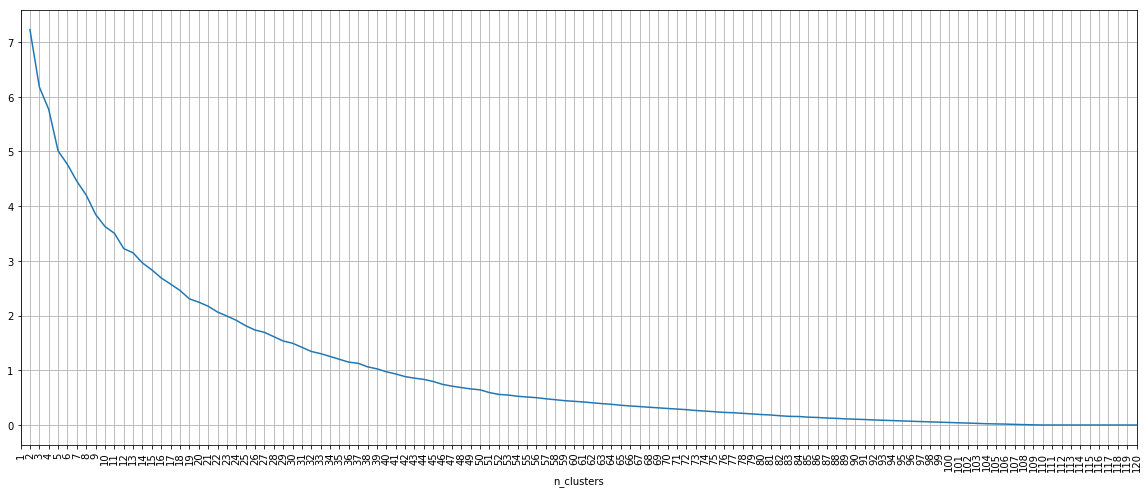

In [10]:
km_results = pd.DataFrame(results).set_index('n_clusters')
km_results['inertia'].plot(xticks=range(1, 121), 
                           figsize=(20,8), 
                           rot=90)
plt.grid(axis='both');

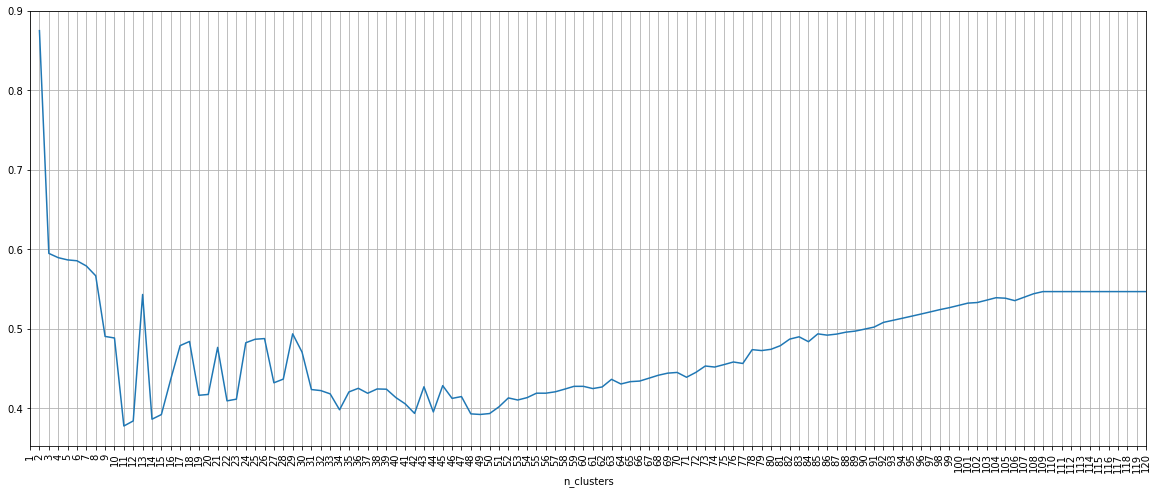

In [11]:
km_results['silhouette_score'].plot(xticks=range(1, 121), 
                                    figsize=(20,8),
                                    rot=90)
plt.grid(axis='both');

Silhouette score dips at 2 clusters, which feels like too few, and then again at 8 clusters. Inertia plot is fairly smooth, with no obvious elbow, although there's one-ish around $k=5$. So let's model with 5 clusters.

In [12]:
kclusters = 5
km_results.loc[kclusters, 'inertia':'silhouette_score']

inertia             5.00995
silhouette_score    0.58653
Name: 5, dtype: object

In [13]:
grid_categories['cluster'] = km_results.loc[kclusters].labels_ + 1

grid_section_centers = cf.calc_grid_centers(grid_size)
grid_categories['grid_section_lat'] = grid_section_centers[:, 0]
grid_categories['grid_section_long'] = grid_section_centers[:, 1]

In [14]:
grid_categories['cluster'].value_counts()

2    196
5     14
1     13
4      1
3      1
Name: cluster, dtype: int64

In [15]:
# create map
map_clusters = cf.draw_rexburg_map()

grid_squares = cf.grid_square_bounds(grid_size)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.tab10(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
for (lat, lon, poi, 
    cluster, square, center) in zip(grid_categories['grid_section_lat'], 
                                   grid_categories['grid_section_long'], 
                                   grid_categories.index, 
                                   grid_categories['cluster'],
                                   grid_squares.reshape(-1, 2, 2),
                                   grid_section_centers):
    
    label = folium.Popup(f'Grid {poi}' + ' Cluster ' + str(cluster + 1))

    folium.Rectangle(
        square,
        popup=label,
        color='gray',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5,
        weight=0.5,
        ).add_to(map_clusters)

    folium.map.Marker(
        center,
        icon=DivIcon(icon_size=(0,0),
                     icon_anchor=(5,7),
                     html=f'<div style="text-align:center;font-size:8pt;'
                          f'color:#2C66AB;font-weight:bold">{cluster}</div>')
        ).add_to(map_clusters)
       
map_clusters

## Analysis & interpretation 

----